### **RoBERT RNN classifier on top of the Fine Tuned Bert Model**

In [ ]:
!pip install transformers==2.10.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import sys
sys.path.append("./drive/MyDrive/ML-Project/RoBERT")

%matplotlib inline
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
import transformers
from transformers import RobertaTokenizer, BertTokenizer, RobertaModel, BertModel, AdamW# get_linear_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup
import time

from utils import *
from Custom_Dataset_Class import ConsumerComplaintsDataset1
from Bert_Classification import Bert_Classification_Model
from RoBERT import RoBERT_Model

from BERT_Hierarchical import BERT_Hierarchical_Model
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
TRAIN_BATCH_SIZE=3
EPOCH=3
validation_split = .2
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=200
OVERLAP_LEN=50
#MAX_LEN=10000000
#MAX_SIZE_DATASET=1000

print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

dataset=ConsumerComplaintsDataset1(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN)


#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler,
    collate_fn=my_collate1)

valid_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler,
    collate_fn=my_collate1)


device=torch.device("cuda")
lr=3e-5#1e-3
num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

model=torch.load("./drive/MyDrive/ML-Project/RoBERT/model1/model_epoch2.pt")

model_rnn=RoBERT_Model(bertFineTuned=list(model.children())[0]).to(device)
optimizer=AdamW(model_rnn.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp=rnn_train_loop_fun1(train_data_loader, model_rnn, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"\nAvg_loss : {epoch_loss:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec)\n")
    t1=time.time()
    output, target, val_losses_tmp=rnn_eval_loop_fun1(valid_data_loader, model_rnn, device)
    print(f"==> Evaluation : Avg_loss = {np.mean(val_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")    
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print("\t The RNN RoBERT model has been saved in drive")
    torch.save(model_rnn, f"./drive/MyDrive/ML-Project/RoBERT/RoBERT_rnn1/RoBERT_rnn_epoch{epoch+1}.pt")

Loading BERT tokenizer...
Data cleaning

=============== EPOCH 1 / 3 ===============

___ batch index = 0 / 4572 (0.00%), loss = 2.2345, time = 0.60 secondes ___
___ batch index = 640 / 4572 (14.00%), loss = 0.7171, time = 259.86 secondes ___
___ batch index = 1280 / 4572 (28.00%), loss = 0.6320, time = 274.24 secondes ___
___ batch index = 1920 / 4572 (41.99%), loss = 0.5845, time = 270.61 secondes ___
___ batch index = 2560 / 4572 (55.99%), loss = 0.5791, time = 266.52 secondes ___
___ batch index = 3200 / 4572 (69.99%), loss = 0.4235, time = 268.74 secondes ___
___ batch index = 3840 / 4572 (83.99%), loss = 0.3199, time = 271.43 secondes ___
___ batch index = 4480 / 4572 (97.99%), loss = 0.4367, time = 270.77 secondes ___

Avg_loss : 0.45, time : ~32.0 min (1920.51 sec)

==> Evaluation : Avg_loss = 0.39, time : 167.66 sec

=====>	{'accuracy': 0.8871061843640606, 'nb exemple': 3428, 'true_prediction': 3041, 'false_prediction': 387}
	 The RNN RoBERT model has been saved in drive

====

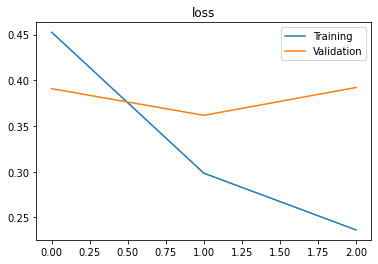

In [ ]:
pd.DataFrame(np.array([[np.mean(x) for x in batches_losses], [np.mean(x) for x in val_losses]]).T,
                   columns=['Training', 'Validation']).plot(title="loss")

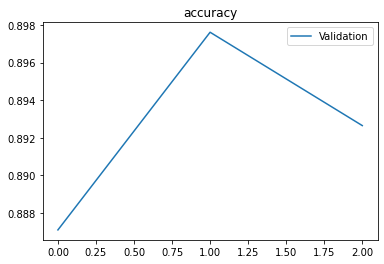

In [ ]:
pd.DataFrame(np.array(val_acc).T,
                   columns=['Validation']).plot(title="accuracy")